# Titanic machine learning - 79%
https://www.kaggle.com/c/titanic

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

%matplotlib inline
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.models import load_model

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = df_train.append(df_test , ignore_index = True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [6]:
df_full.drop(['PassengerId','Embarked'],axis=1,inplace=True)

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
dtypes: float64(3), int64(3), object(4)
memory usage: 102.4+ KB


## Name - title

In [8]:
df_full['title'] = df_full['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip(' '))
df_full['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Lady              1
Dona              1
Sir               1
Don               1
Jonkheer          1
Mme               1
Capt              1
the Countess      1
Name: title, dtype: int64

In [9]:
### Merging titles

# untitled women
df_full['title'] = df_full['title'].apply(lambda x: 'Miss' if x in ['Mlle'] else x)
df_full['title'] = df_full['title'].apply(lambda x: 'Mrs' if x in ['Mme','Ms'] else x)

# titled women
df_full['title'] = df_full['title'].apply(lambda x: 'Mrs_titled' if x in [
    'Dona',
    'Lady',
    'the Countess'
] else x)

# titled people
df_full['title'] = df_full['title'].apply(lambda x: 'Mr_titled' if x in [
    'Master',
    'Dr',
    'Rev',
    'Col',
    'Major',
    'Sir',
    'Don',
    'Capt',
    'Jonkheer'
] else x)

df_full['title'].value_counts()

Mr            757
Miss          262
Mrs           200
Mr_titled      87
Mrs_titled      3
Name: title, dtype: int64

In [10]:
# Too few titled women -> gathered with womens
df_full['title'] = df_full['title'].apply(lambda x: 'Mrs' if x in ['Mrs_titled'] else x)

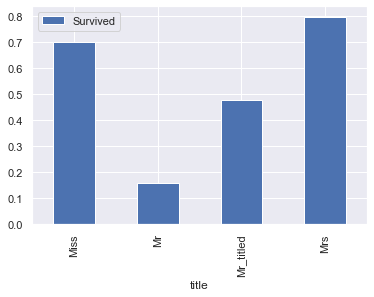

In [11]:
# check survivak mean in function of title
df_full[['title', 'Survived']].groupby(['title']).mean().plot(kind='bar')

## Family members

In [12]:
# Sum all familiy members
df_full['relatives'] = df_full['SibSp']+df_full['Parch']+1 # 1 person + x siblings + x children
df_full['relatives'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: relatives, dtype: int64

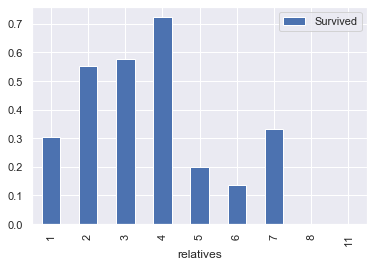

In [13]:
# check survival mean in function of title
df_full[['relatives', 'Survived']].groupby(['relatives']).mean().plot(kind='bar')

## Fares

In [14]:
df_full[df_full['Fare'].isna() == True]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,title,relatives
1043,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,Mr,1


In [15]:
# Mean fare function of Pclass','Age','relatives'
fare_agg = df_full[[
    'Fare', 
    'Pclass', 
    'Age',
    'relatives']].groupby(['Pclass','Age','relatives']).mean().reset_index()

# Fare esitmtor for Storey, Mr. Thomas
fare_estimator = fare_agg[
    (fare_agg['Pclass'] == 3)
    & (fare_agg['relatives'] == 1)
    & (fare_agg['Age'] < 70)
    & (fare_agg['Age'] > 50)
]['Fare'].mean()

df_full['Fare'][1043] = fare_estimator

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [16]:
df_full.iloc[1043]

Survived                    NaN
Pclass                        3
Name         Storey, Mr. Thomas
Sex                        male
Age                        60.5
SibSp                         0
Parch                         0
Ticket                     3701
Fare                    7.74884
Cabin                       NaN
title                        Mr
relatives                     1
Name: 1043, dtype: object

## Age

In [17]:
df_full['Age'] = pd.to_numeric(df_full['Age'], errors='coerce')

df_full.loc[df_full['Age'] <= 11, 'Age'] = 0
df_full.loc[(df_full['Age'] > 11) & (df_full['Age'] <= 18), 'Age'] = 1
df_full.loc[(df_full['Age'] > 18) & (df_full['Age'] <= 22), 'Age'] = 2
df_full.loc[(df_full['Age'] > 22) & (df_full['Age'] <= 27), 'Age'] = 3
df_full.loc[(df_full['Age'] > 27) & (df_full['Age'] <= 33), 'Age'] = 4
df_full.loc[(df_full['Age'] > 33) & (df_full['Age'] <= 40), 'Age'] = 5
df_full.loc[(df_full['Age'] > 40) & (df_full['Age'] <= 66), 'Age'] = 6
df_full.loc[df_full['Age'] > 66, 'Age'] = 6

df_full['Age'].value_counts()

6.0    227
4.0    179
3.0    171
2.0    140
5.0    136
1.0    103
0.0     90
Name: Age, dtype: int64

In [18]:
# Determining missing ages function of title, fare and siblings
df_extract = df_full[['title','SibSp','Fare','Age']]
df_extract = pd.concat([df_extract, pd.get_dummies(df_extract['title']),], axis = 1).drop('title',axis=1)
df_extract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SibSp      1309 non-null   int64  
 1   Fare       1309 non-null   float64
 2   Age        1046 non-null   float64
 3   Miss       1309 non-null   uint8  
 4   Mr         1309 non-null   uint8  
 5   Mr_titled  1309 non-null   uint8  
 6   Mrs        1309 non-null   uint8  
dtypes: float64(2), int64(1), uint8(4)
memory usage: 35.9 KB


In [19]:
# Select features and labels
X = df_extract.dropna().drop('Age', axis=1)
y = df_full['Age'].dropna()
X_user = df_extract.loc[np.isnan(df_full['Age'])].drop('Age', axis=1) # All rows w/o Age

In [20]:
# Generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# cross-validator : ShuffleSplit 
ss = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42) # To avoid over-fitting

### Import regressor ###
reg = RandomForestRegressor()

# definition of the pipeline
pipeline = Pipeline(steps = [("RDFR",reg)])   

# parameters to tune 
param_grid = {"RDFR__n_estimators":[100,200]}

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = ss)

# training classifier
print (" > training classifier:")
t0 = time()
grid.fit(X_train, y_train)
print ("training time: ", round(time()-t0, 3), "s")

# best classifier using the cross-validator and the Stratified Shuffle Split 
reg = grid.best_estimator_

# predicition with the classifier
t0 = time()
pred = reg.predict(X_test)
print ("testing time: ", round(time()-t0, 3), "s")

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

RMSE = np.sqrt(mean_squared_error(y_test, pred))
R2 = r2_score(y_test, pred)
print('RMSE:',RMSE,'\nr2:',R2)

 > training classifier:
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.9s finished


training time:  9.542 s
testing time:  0.031 s

 > Best grid search:
{'RDFR__n_estimators': 200}
RMSE: 1.615009327651131 
r2: 0.23381148268145235


In [21]:
# prediction based on classifier
y_pred = np.round(reg.predict(X_user),0)
# fill missing ages
df_full['Age'].loc[df_full['Age'].isnull()] = y_pred

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    float64
 1   Pclass     1309 non-null   int64  
 2   Name       1309 non-null   object 
 3   Sex        1309 non-null   object 
 4   Age        1309 non-null   float64
 5   SibSp      1309 non-null   int64  
 6   Parch      1309 non-null   int64  
 7   Ticket     1309 non-null   object 
 8   Fare       1309 non-null   float64
 9   Cabin      295 non-null    object 
 10  title      1309 non-null   object 
 11  relatives  1309 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## Tickets

In [23]:
# Check ticket layout by prefix of numerical part (if any)
def extract_ticket_prefix(ticket_str):
    if ticket_str.split(' ')[0] == ticket_str:
        return ticket_str[0]
    else:
        return ticket_str.split(' ')[1][0]

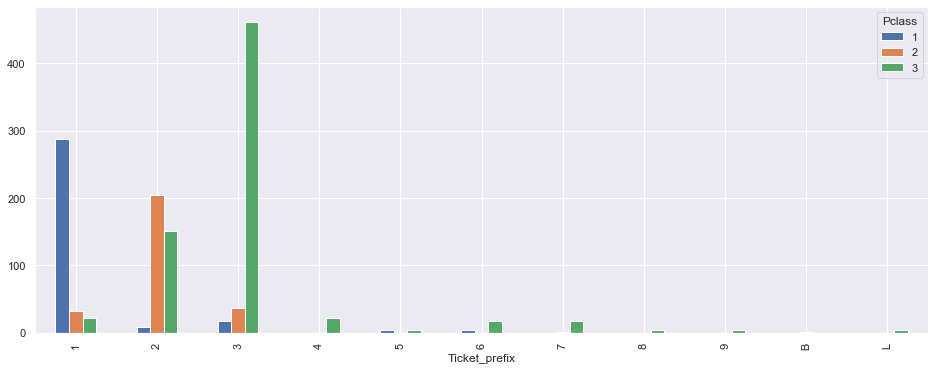

In [24]:
df_full['Ticket_prefix'] = df_full['Ticket'].apply(extract_ticket_prefix)

df_pivoted = df_full.pivot_table(index=['Ticket_prefix'],columns=['Pclass'],aggfunc='size', fill_value=0)
df_pivoted.plot(kind='bar', figsize=(16, 6))

Correlated with Pclass -> to drop
## Cabin

In [25]:
df_full['Cabin_prefix'] = df_full['Cabin'].apply(lambda x: str(x)[0] if pd.isna(x) == False else 'Unknown')
df_full['Cabin_prefix'].value_counts()

Unknown    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: Cabin_prefix, dtype: int64

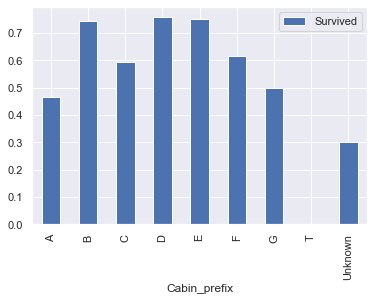

In [26]:
# check survival mean in function of cabin prefix (deck maybe ?)
df_full[['Cabin_prefix', 'Survived']].groupby(['Cabin_prefix']).mean().plot(kind='bar')

In [27]:
### Merging decks
df_full['Cabin_prefix'] = df_full['Cabin_prefix'].apply(lambda x: 'Top_deck' if x in ['A','B','C'] else x)
df_full['Cabin_prefix'] = df_full['Cabin_prefix'].apply(lambda x: 'Mid_deck' if x in ['D','E'] else x)
df_full['Cabin_prefix'] = df_full['Cabin_prefix'].apply(lambda x: 'Low_deck' if x in ['F','G','T'] else x)

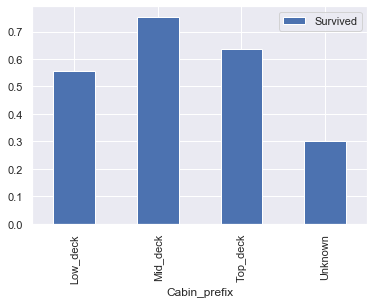

In [28]:
# check survival mean in function of cabin prefix (deck maybe ?)
df_full[['Cabin_prefix', 'Survived']].groupby(['Cabin_prefix']).mean().plot(kind='bar')

In [29]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         1309 non-null   int64  
 2   Name           1309 non-null   object 
 3   Sex            1309 non-null   object 
 4   Age            1309 non-null   float64
 5   SibSp          1309 non-null   int64  
 6   Parch          1309 non-null   int64  
 7   Ticket         1309 non-null   object 
 8   Fare           1309 non-null   float64
 9   Cabin          295 non-null    object 
 10  title          1309 non-null   object 
 11  relatives      1309 non-null   int64  
 12  Ticket_prefix  1309 non-null   object 
 13  Cabin_prefix   1309 non-null   object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


## Machine learning

In [30]:
# get dummies of relevant columns
df_full = pd.concat([df_full, pd.get_dummies(df_full['title']),], axis = 1)
df_full = pd.concat([df_full, pd.get_dummies(df_full['Sex']),], axis = 1)
df_full = pd.concat([df_full, pd.get_dummies(df_full['Cabin_prefix']),], axis = 1)

In [31]:
df_full.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Miss,Mr,Mr_titled,Mrs,female,male,Low_deck,Mid_deck,Top_deck,Unknown
0,0.0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,...,0,1,0,0,0,1,0,0,0,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,71.2833,C85,...,0,0,0,1,1,0,0,0,1,0
2,1.0,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,7.9250,NaN,...,1,0,0,0,1,0,0,0,0,1
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,53.1000,C123,...,0,0,0,1,1,0,0,0,1,0
4,0.0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,8.0500,NaN,...,0,1,0,0,0,1,0,0,0,1


In [32]:
df_full.drop([
    'Name',
    'Sex',
    'SibSp',
    'Parch',
    'Ticket',
    'Cabin',
    'title',
    'Ticket_prefix',
    'Cabin_prefix'
],axis=1,inplace=True)

In [33]:
df_full.head()

,Survived,Pclass,Age,Fare,relatives,Miss,Mr,Mr_titled,Mrs,female,male,Low_deck,Mid_deck,Top_deck,Unknown
0,0.0,3,2.0,7.2500,2,0,1,0,0,0,1,0,0,0,1
1,1.0,1,5.0,71.2833,2,0,0,0,1,1,0,0,0,1,0
2,1.0,3,3.0,7.9250,1,1,0,0,0,1,0,0,0,0,1
3,1.0,1,5.0,53.1000,2,0,0,0,1,1,0,0,0,1,0
4,0.0,3,5.0,8.0500,1,0,1,0,0,0,1,0,0,0,1


In [34]:
# Features from 1st part of the df
X_train = df_full[0:891].drop('Survived', axis=1).values
# Labels from 1st part of the df
y_train = df_full[0:891]['Survived'].values
# Features from 2nd part of the df
X_test = df_full[891:].drop('Survived', axis=1).values
# Labels from 2nd part of the df
y_test = np.array(pd.read_csv('gender_submission.csv')['Survived'])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(891, 14)
(891,)
(418, 14)
(418,)


In [35]:
# Neural Net
model = Sequential()
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 135       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compiling
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
# train the model
checkpointer = ModelCheckpoint(filepath='titanic.nn.best.hdf5', verbose=0, save_best_only=True)

history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.33, 
    epochs=300, 
    callbacks=[checkpointer],
    batch_size=32, 
    verbose=1
)


Train on 596 samples, validate on 295 samples
Epoch 1/300
596/596 [==============================] - 0s 647us/step - loss: 0.6924 - accuracy: 0.5990 - val_loss: 0.6909 - val_accuracy: 0.6339
Epoch 2/300
596/596 [==============================] - 0s 79us/step - loss: 0.6906 - accuracy: 0.6074 - val_loss: 0.6885 - val_accuracy: 0.6407
Epoch 3/300
596/596 [==============================] - 0s 105us/step - loss: 0.6889 - accuracy: 0.6057 - val_loss: 0.6853 - val_accuracy: 0.6644
Epoch 4/300
596/596 [==============================] - 0s 116us/step - loss: 0.6867 - accuracy: 0.6107 - val_loss: 0.6816 - val_accuracy: 0.6746
Epoch 5/300
596/596 [==============================] - 0s 90us/step - loss: 0.6836 - accuracy: 0.6409 - val_loss: 0.6739 - val_accuracy: 0.6983
Epoch 6/300
596/596 [==============================] - 0s 90us/step - loss: 0.6787 - accuracy: 0.6594 - val_loss: 0.6618 - val_accuracy: 0.7288
Epoch 7/300
596/596 [==============================] - 0s 79us/step - loss: 0.6724 - a

Epoch 56/300
596/596 [==============================] - 0s 79us/step - loss: 0.4476 - accuracy: 0.8003 - val_loss: 0.4219 - val_accuracy: 0.8169
Epoch 57/300
596/596 [==============================] - 0s 90us/step - loss: 0.4522 - accuracy: 0.8037 - val_loss: 0.3986 - val_accuracy: 0.8102
Epoch 58/300
596/596 [==============================] - 0s 90us/step - loss: 0.4486 - accuracy: 0.8003 - val_loss: 0.4280 - val_accuracy: 0.8169
Epoch 59/300
596/596 [==============================] - 0s 105us/step - loss: 0.4499 - accuracy: 0.8104 - val_loss: 0.3971 - val_accuracy: 0.8102
Epoch 60/300
596/596 [==============================] - 0s 79us/step - loss: 0.4541 - accuracy: 0.8020 - val_loss: 0.4089 - val_accuracy: 0.8203
Epoch 61/300
596/596 [==============================] - 0s 116us/step - loss: 0.4469 - accuracy: 0.8003 - val_loss: 0.4024 - val_accuracy: 0.8203
Epoch 62/300
596/596 [==============================] - 0s 90us/step - loss: 0.4480 - accuracy: 0.8054 - val_loss: 0.3989 - val_

596/596 [==============================] - 0s 63us/step - loss: 0.4416 - accuracy: 0.8104 - val_loss: 0.3857 - val_accuracy: 0.8271
Epoch 113/300
596/596 [==============================] - 0s 79us/step - loss: 0.4427 - accuracy: 0.8121 - val_loss: 0.3869 - val_accuracy: 0.8271
Epoch 114/300
596/596 [==============================] - 0s 90us/step - loss: 0.4475 - accuracy: 0.8054 - val_loss: 0.4036 - val_accuracy: 0.8203
Epoch 115/300
596/596 [==============================] - 0s 79us/step - loss: 0.4394 - accuracy: 0.8121 - val_loss: 0.3865 - val_accuracy: 0.8305
Epoch 116/300
596/596 [==============================] - 0s 90us/step - loss: 0.4416 - accuracy: 0.8121 - val_loss: 0.3878 - val_accuracy: 0.8305
Epoch 117/300
596/596 [==============================] - 0s 105us/step - loss: 0.4410 - accuracy: 0.8037 - val_loss: 0.3990 - val_accuracy: 0.8169
Epoch 118/300
596/596 [==============================] - 0s 90us/step - loss: 0.4422 - accuracy: 0.8070 - val_loss: 0.3928 - val_accuracy

Epoch 168/300
596/596 [==============================] - 0s 90us/step - loss: 0.4380 - accuracy: 0.8221 - val_loss: 0.3833 - val_accuracy: 0.8373
Epoch 169/300
596/596 [==============================] - 0s 79us/step - loss: 0.4374 - accuracy: 0.8255 - val_loss: 0.3843 - val_accuracy: 0.8373
Epoch 170/300
596/596 [==============================] - 0s 90us/step - loss: 0.4376 - accuracy: 0.8289 - val_loss: 0.3819 - val_accuracy: 0.8373
Epoch 171/300
596/596 [==============================] - 0s 79us/step - loss: 0.4413 - accuracy: 0.8020 - val_loss: 0.4146 - val_accuracy: 0.8169
Epoch 172/300
596/596 [==============================] - 0s 90us/step - loss: 0.4379 - accuracy: 0.8255 - val_loss: 0.3784 - val_accuracy: 0.8373
Epoch 173/300
596/596 [==============================] - 0s 63us/step - loss: 0.4379 - accuracy: 0.8154 - val_loss: 0.3876 - val_accuracy: 0.8373
Epoch 174/300
596/596 [==============================] - 0s 79us/step - loss: 0.4368 - accuracy: 0.8188 - val_loss: 0.3815 -

596/596 [==============================] - 0s 90us/step - loss: 0.4329 - accuracy: 0.8305 - val_loss: 0.3830 - val_accuracy: 0.8339
Epoch 225/300
596/596 [==============================] - 0s 79us/step - loss: 0.4339 - accuracy: 0.8138 - val_loss: 0.3855 - val_accuracy: 0.8305
Epoch 226/300
596/596 [==============================] - 0s 90us/step - loss: 0.4353 - accuracy: 0.8305 - val_loss: 0.3747 - val_accuracy: 0.8441
Epoch 227/300
596/596 [==============================] - 0s 116us/step - loss: 0.4315 - accuracy: 0.8121 - val_loss: 0.4082 - val_accuracy: 0.8237
Epoch 228/300
596/596 [==============================] - 0s 79us/step - loss: 0.4451 - accuracy: 0.8188 - val_loss: 0.3788 - val_accuracy: 0.8373
Epoch 229/300
596/596 [==============================] - 0s 90us/step - loss: 0.4407 - accuracy: 0.8205 - val_loss: 0.3756 - val_accuracy: 0.8441
Epoch 230/300
596/596 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.87 - 0s 79us/step - loss: 0.4392 - accuracy

Epoch 280/300
596/596 [==============================] - 0s 168us/step - loss: 0.4357 - accuracy: 0.8221 - val_loss: 0.3740 - val_accuracy: 0.8441
Epoch 281/300
596/596 [==============================] - 0s 142us/step - loss: 0.4322 - accuracy: 0.8171 - val_loss: 0.3948 - val_accuracy: 0.8305
Epoch 282/300
596/596 [==============================] - 0s 142us/step - loss: 0.4334 - accuracy: 0.8305 - val_loss: 0.3851 - val_accuracy: 0.8271
Epoch 283/300
596/596 [==============================] - 0s 168us/step - loss: 0.4308 - accuracy: 0.8305 - val_loss: 0.3824 - val_accuracy: 0.8305
Epoch 284/300
596/596 [==============================] - 0s 142us/step - loss: 0.4314 - accuracy: 0.8305 - val_loss: 0.3904 - val_accuracy: 0.8271
Epoch 285/300
596/596 [==============================] - 0s 116us/step - loss: 0.4306 - accuracy: 0.8305 - val_loss: 0.3768 - val_accuracy: 0.8339
Epoch 286/300
596/596 [==============================] - 0s 116us/step - loss: 0.4382 - accuracy: 0.8138 - val_loss: 0

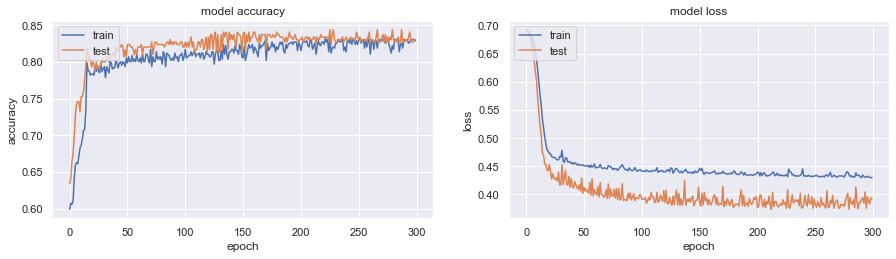

In [39]:
plt.figure(1, figsize = (15,8)) 

# summarize history for accuracy
plt.subplot(221) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(222) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [38]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 95.4545%


In [58]:
# Submit predictions
predictions = [0 if val[0] < 0.5 else 1 for val in model.predict(X_test)]

submission = pd.DataFrame({
    'PassengerId': pd.read_csv('gender_submission.csv')['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)